This notebook provides code for transforming incorporating the sinusoidal stimulus parameters into a Gaussian process, and generates the panels of Figure 6.

In [14]:
%matplotlib inline

import GPy
import h5py
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d
# from scipy.stats import chisqprob
from scipy.stats import chi2
import seaborn as sns

from util.load_hdf5 import *
from util.zscore import *
from util.compute_bounds import *
from util.fill_bounds import *

sns.set_style('ticks')

In [247]:
directories = json.load(open('directories.json'))

off_chirp = load_hdf5(directories['data'] + 'SMP_M1_RR2_IPL2OFF_ChirpI.h5')
off_chirp_df = pd.read_csv(directories['data'] + 'SMP_M1_RR2_IPL2OFF_ChirpI.csv', index_col = 0)
# off_chirp_df = off_chirp_df.groupby(['roi', 'frame']).mean().reset_index()

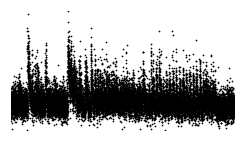

In [801]:
sns.set_style('white')

target_roi = 2
traces = off_chirp_df.loc[off_chirp_df['roi'] == target_roi, 'y']
tpnts  = off_chirp_df.loc[off_chirp_df['roi'] == target_roi, 'x_t']
tpnts_warp = off_chirp_df.loc[off_chirp_df['roi'] == target_roi, 'x_t_warped']

stimulus_duration = 66

stimulus_mask = tpnts > (stimulus_duration / 2)
traces  = traces[stimulus_mask]
tpnts  = tpnts[stimulus_mask]
tpnts_warp = tpnts_warp[stimulus_mask]
tpnts -= stimulus_duration / 2

fig, ax = plt.subplots(1)

ax.scatter(tpnts, traces, color = 'k', s = 0.5)

ax.set_xlim(0, stimulus_duration / 2);
ax.set_ylim(traces.min(), traces.max())
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_xlabel('', fontsize=10)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, ax = ax)
ax.set_aspect(2)

fig.set_size_inches(4, 2.5)

In [802]:
m = GPy.models.SparseGPRegression(
    tpnts_warp[:, None],
    traces[:, None],
    num_inducing = 300,
    kernel = GPy.kern.RBF(1)
)

m.optimize_restarts(1, messages = True, max_iters = 20)

Optimization restart 1/1, f = 21946.52395972243


In [803]:
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression()
stimulus_mask = off_chirp_df['x_t'] > 33
iso_reg.fit(off_chirp_df['x_t_warped'][stimulus_mask], off_chirp_df['x_t'][stimulus_mask])

n_tpnts = 32 * 20
x_new = np.linspace(off_chirp_df['x_t'].min(), off_chirp_df['x_t'].max() / 2, n_tpnts)
x_new_unwarp = iso_reg.transform(x_new)

mu, sig = m.predict(x_new[:, None], include_likelihood = False)
_, sig_outer = m.predict(x_new[:, None], include_likelihood = True)

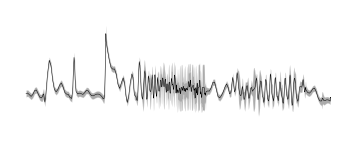

In [804]:
sns.set_style('white')

fig, ax = plt.subplots(1)

ax.plot(x_new_unwarp, mu, color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(mu, sig, n_sigma = 3)
ax.fill_between(x_new_unwarp, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.33)

# ax.set_xlim(0, 32)
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_yticklabels([]);
ax.set_xticklabels([]);
ax.set_ylim(-3, 4)
ax.set_aspect(2)
sns.despine(left = True, bottom = True, ax = ax)

# fig.set_size_inches(4, 1.5)

In [806]:
off_sine = load_hdf5(directories['data'] + 'SMP_M1_RR2_IPL2OFF_Sine.h5')
off_sine_df = pd.read_csv(directories['data'] + 'SMP_M1_RR2_IPL2OFF_Sine.csv', index_col = 0)
off_sine_df = off_sine_df.groupby(['roi', 'frame']).mean().reset_index()
off_sine_df['trial'] -= 3

In [807]:
sine_conditions = pd.read_csv(directories['misc'] + 'sine_conditions.csv', header = None)

sine_conditions.columns = ["shape", "frequency", "contrast"]

sine_conditions['trial'] = np.arange(len(sine_conditions))

off_sine_df = sine_conditions.merge(off_sine_df)

stimulation_start = off_sine_df['t'].min()

roi_df = off_sine_df.loc[off_sine_df['roi'] == target_roi, :]

x = roi_df['t']
y = roi_df['y']

stimulus = []
temporal_freq = 50

for itx, row in sine_conditions.iterrows():
    if row['shape'] != 0:
        stimulus.append(np.sin(np.linspace(0, 2 * np.pi, temporal_freq) * row['frequency']) * row['contrast'])
    else:
        stimulus.append(np.ones(temporal_freq) * np.nan)

sine_stimulus = np.hstack(stimulus)
sine_stimulus /= np.nanmax(sine_stimulus)
sine_tpnts = np.linspace(0, len(sine_conditions), len(sine_conditions) * temporal_freq) + stimulation_start

# plt.savefig('sine.png', dpi = 800)

 /usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:946: UserWarning:You are merging on int and float columns where the float values are not equal to their int representation


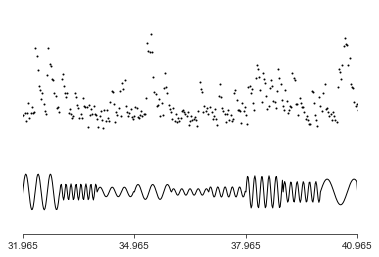

In [808]:
stimulus_offset = -4
# for itx in range(40):
sns.set_style('ticks')
fig, ax = plt.subplots(1)
ax.plot(sine_tpnts, sine_stimulus + stimulus_offset, linewidth = 1, color = 'k')

# ax.plot(x, y, linewidth = 0.5, color = 'k')
stimulus_delay = 0
ax.scatter(x, y, s = 1, color = 'k', marker = 'o')

start = stimulation_start + 18
ax.set_xlim(start, start + 9)
ax.get_yaxis().set_visible(False)
plt.xticks([start, start + 3, start + 6, start + 9])
# ax.set_xticklabels([0, 3, 6, 9])
sns.despine(left = True, ax = ax, offset = 10)
# ax.set_xlabel('Time (s)', fontsize = 1);
plt.tick_params(axis='both', which='major', labelsize = 'medium')

# fig.set_size_inches(4, 3)
plt.show()
fig.set_size_inches(16, 3)

# plt.savefig(directories['figs'] + 'hierarchical/' + 'roi_mean_traces.png', **fig_p)

In [809]:
# shape_bool = off_sine_df['shape'] == 1
# roi_bool = off_sine_df['roi'] == target_roi
# roi_df = off_sine_df.loc[shape_bool & roi_bool, :]

roi_bool = off_sine_df['roi'] == target_roi
roi_df = off_sine_df.loc[roi_bool, :]

In [876]:
stimulus_delay = 0
trial_duration = np.mean(np.diff(off_sine['Triggertimes']))
roi_df['x_t'] = (roi_df['t'] - stimulus_delay) % trial_duration
roi_df['phase'] = (roi_df['x_t'] * roi_df['frequency'] * 2 * np.pi) #% np.pi

x_cos = np.cos(roi_df['phase'].values)[:, None]
x_sin = np.sin(roi_df['phase'].values)[:, None]
x_frequency = roi_df['frequency'].values[:, None]
x_contrast = roi_df['contrast'].values[:, None]

X = np.concatenate([x_cos, x_sin, x_frequency, x_contrast], axis = 1)

x_t = roi_df['x_t'][:, None]

y = roi_df['y'][:, None]

 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


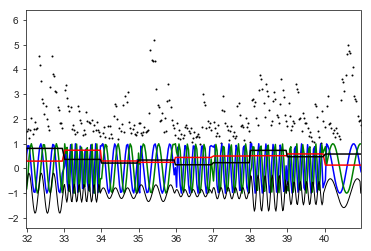

In [811]:
fig, ax = plt.subplots(1)

ax.scatter(roi_df['t'], y + 2, s = 1, color = 'k', marker = 'o')

ax.plot(roi_df['t'], x_cos, color = 'blue')
ax.plot(roi_df['t'], x_sin, color = 'green')
ax.plot(roi_df['t'], x_frequency / 10, color = 'red')
ax.plot(roi_df['t'], x_contrast / 100, color = 'black')

start = stimulation_start + 18
ax.set_xlim(start, start + 9)
ax.plot(sine_tpnts, sine_stimulus - 1, linewidth = 1, color = 'k')

In [812]:
ARD = False
k1 = GPy.kern.RBF(4, ARD = ARD, active_dims = [0, 1, 2, 3]) \
    + GPy.kern.RBF(3, ARD = ARD, active_dims = [0, 1, 3]) \
    + GPy.kern.RBF(3, ARD = ARD, active_dims = [0, 1, 2]) \
    + GPy.kern.RBF(2, ARD = ARD, active_dims = [0, 1]) \
    + GPy.kern.RBF(1, ARD = ARD, active_dims = [2,]) \
    + GPy.kern.RBF(1, ARD = ARD, active_dims = [3,])

In [813]:
m1 = GPy.models.SparseGPRegression(
        X,
        y,
        num_inducing = 500,
        kernel = k1
    )

In [814]:
m1.optimize_restarts(3, messages = True, max_iters = 50)

Optimization restart 1/3, f = 2738.948521238707


Optimization restart 2/3, f = 2845.5054245199085


Optimization restart 3/3, f = 2852.490000157592


ValueError: x and y must have same first dimension, but have shapes (2325,) and (200, 1)

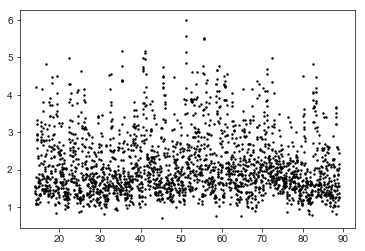

In [855]:
post_mu, post_sig = m1.predict(X, include_likelihood = False)

sns.set_style('ticks')

fig, ax = plt.subplots(1)

x_t = roi_df['t']
ax.scatter(x_t, roi_df['y'] + 2, s = 2, color = 'k', marker = 'o')
ax.plot(x_t, post_mu, linewidth = 0.5, color = 'k')

upper, lower = compute_bounds(post_mu, post_sig, n_sigma = 3)
ax.fill_between(x_t, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

stimulus_offset = -2
ax.plot(sine_tpnts, sine_stimulus + stimulus_offset, linewidth = 0.75, color = 'k')

ax.get_yaxis().set_visible(False)
plt.xlim(32, 41)
plt.xticks(np.arange(0, 12, 3) + 32)
ax.set_xticklabels(np.arange(0, 12, 3))
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(left = True, ax = ax)

fig.set_size_inches(4, 4)

In [829]:
optimize_p = {
    'messages': False,
    'max_iters': 50,
}

n_repeats = 5
n_inducing = 500
inc_lik = False
ARD = False

kernel_alpha = GPy.kern.RBF(2, ARD = ARD, active_dims = [0, 1]) # Time
kernel_beta = GPy.kern.RBF(1, ARD = ARD, active_dims = [2,]) # Frequency
kernel_gamma = GPy.kern.RBF(1, ARD = ARD, active_dims = [3,]) # Contrast
kernel_delta = GPy.kern.RBF(3, ARD = ARD, active_dims = [0, 1, 2]) # Time-Contrast
kernel_epsilon = GPy.kern.RBF(3, ARD = ARD, active_dims = [0, 1, 3]) # Time-Frequency
kernel_zeta = GPy.kern.RBF(2, ARD = ARD, active_dims = [1, 2]) # Contrast-Frequency
kernel_eta = GPy.kern.RBF(4, ARD = ARD, active_dims = [0, 1, 2, 3]) # Time-Contrast-Frequency

kernels = [kernel_alpha, kernel_beta, kernel_gamma, kernel_delta, kernel_epsilon, kernel_zeta, kernel_eta]

In [832]:
gp_1 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernel_alpha)
gp_1.optimize_restarts(n_repeats, **optimize_p)

gp_2 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernel_beta)
gp_2.optimize_restarts(n_repeats, **optimize_p)

gp_3 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernel_gamma)
gp_3.optimize_restarts(n_repeats, **optimize_p)

gp_4 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernel_delta)
gp_4.optimize_restarts(n_repeats, **optimize_p)

gp_5 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernel_epsilon)
gp_5.optimize_restarts(n_repeats, **optimize_p)

gp_6 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernel_zeta)
gp_6.optimize_restarts(n_repeats, **optimize_p)

gp_7 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernel_eta)
gp_7.optimize_restarts(n_repeats, **optimize_p)

log_likelihoods_1 = np.asarray([gp_.log_likelihood() for gp_ in [gp_1, gp_2, gp_3, gp_4, gp_5, gp_6, gp_7]])
pass_1_max = log_likelihoods_1.argmax()
pass_1_max

 /usr/local/lib/python3.6/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 2 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Optimization restart 1/5, f = 2875.918527533955
Optimization restart 2/5, f = 2875.918527843741
Optimization restart 3/5, f = 2875.91852744487
Optimization restart 4/5, f = 2875.918527453842
Optimization restart 5/5, f = 2875.918527441575


 /usr/local/lib/python3.6/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Optimization restart 1/5, f = 2840.7251998708066
Optimization restart 2/5, f = 2853.892150647647
Optimization restart 3/5, f = 2853.829431430799
Optimization restart 4/5, f = 2853.779987567684
Optimization restart 5/5, f = 2854.0366144327454


 /usr/local/lib/python3.6/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Optimization restart 1/5, f = 2766.227583958058
Optimization restart 2/5, f = 2893.473745186445
Optimization restart 3/5, f = 2893.4737735173417
Optimization restart 4/5, f = 2893.4737601718325
Optimization restart 5/5, f = 2893.473874257703


 /usr/local/lib/python3.6/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 3 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Optimization restart 1/5, f = 2845.288203484711
Optimization restart 2/5, f = 2848.325647319959
Optimization restart 3/5, f = 2846.7345850713086
Optimization restart 4/5, f = 2856.8752842980057
Optimization restart 5/5, f = 2847.1833103280987


 /usr/local/lib/python3.6/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 3 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Optimization restart 1/5, f = 2809.750806772473
Optimization restart 2/5, f = 2893.473740670868
Optimization restart 3/5, f = 2893.4737392547904
Optimization restart 4/5, f = 2893.4737382780763
Optimization restart 5/5, f = 2893.4737421331665


 /usr/local/lib/python3.6/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 2 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Optimization restart 1/5, f = 2845.0701309810497
Optimization restart 2/5, f = 2845.5193609645225
Optimization restart 3/5, f = 2846.1877506026335
Optimization restart 4/5, f = 2845.681555003877
Optimization restart 5/5, f = 2845.353430138755
Optimization restart 1/5, f = 2742.4755161567123
Optimization restart 2/5, f = 2893.4737407945486
Optimization restart 3/5, f = 2893.473740021801
Optimization restart 4/5, f = 2893.473742777751
Optimization restart 5/5, f = 2893.473849157223


6

In [833]:
messages = False
pass_2_kernels = kernels[:]
pass_2_kernels = np.delete(pass_2_kernels, pass_1_max)

gp_8 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[0])
gp_8.optimize_restarts(n_repeats, **optimize_p)

gp_9 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[1])
gp_9.optimize_restarts(n_repeats, **optimize_p)

gp_10 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[2])
gp_10.optimize_restarts(n_repeats, **optimize_p)

gp_11 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[3])
gp_11.optimize_restarts(n_repeats, **optimize_p)

gp_12 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[4])
gp_12.optimize_restarts(n_repeats, **optimize_p)

gp_13 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[5])
gp_13.optimize_restarts(n_repeats, **optimize_p)

log_likelihoods_2 = np.asarray([gp_.log_likelihood() for gp_ in [gp_8, gp_9, gp_10, gp_11, gp_12, gp_13]])
pass_2_max = log_likelihoods_2.argmax()
pass_2_max

Optimization restart 1/5, f = 2741.6876542642394
Optimization restart 2/5, f = 2875.920093819645
Optimization restart 3/5, f = 2875.918556460644
Optimization restart 4/5, f = 2875.9191373914596
Optimization restart 5/5, f = 2875.9185275458713
Optimization restart 1/5, f = 2739.6571598267255
Optimization restart 2/5, f = 2889.587923485205
Optimization restart 3/5, f = 2889.5912644638925
Optimization restart 4/5, f = 2853.8621562516014
Optimization restart 5/5, f = 2857.7087604755757
Optimization restart 1/5, f = 2748.427273789061
Optimization restart 2/5, f = 2893.4738087951964
Optimization restart 3/5, f = 2893.4737628974963
Optimization restart 4/5, f = 2893.473796179516
Optimization restart 5/5, f = 2893.4737467178443
Optimization restart 1/5, f = 2737.973369742623
Optimization restart 2/5, f = 2847.3794627597936
Optimization restart 3/5, f = 2853.955470075304
Optimization restart 4/5, f = 2848.3855773677574
Optimization restart 5/5, f = 2847.556654458741
Optimization restart 1/5, f 

5

In [834]:
messages = False
pass_3_kernels = pass_2_kernels[:]
pass_3_kernels = np.delete(pass_3_kernels, pass_2_max)

gp_14 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[0])
gp_14.optimize_restarts(n_repeats, **optimize_p)

gp_15 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[1])
gp_15.optimize_restarts(n_repeats, **optimize_p)

gp_16 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[2])
gp_16.optimize_restarts(n_repeats, **optimize_p)

gp_17 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[3])
gp_17.optimize_restarts(n_repeats, **optimize_p)

gp_18 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[4])
gp_18.optimize_restarts(n_repeats, **optimize_p)

log_likelihoods_3 = np.asarray([gp_.log_likelihood() for gp_ in [gp_14, gp_15, gp_16, gp_17, gp_18]])
pass_3_max = log_likelihoods_3.argmax()
pass_3_max

Optimization restart 1/5, f = 2737.2859369044377
Optimization restart 2/5, f = 2845.668567968843
Optimization restart 3/5, f = 2845.5564766702996
Optimization restart 4/5, f = 2845.698074227224
Optimization restart 5/5, f = 2851.5599161457435
Optimization restart 1/5, f = 2734.8384476007873
Optimization restart 2/5, f = 2847.9131743461926
Optimization restart 3/5, f = 2844.899547207157
Optimization restart 4/5, f = 2846.2050040309778
Optimization restart 5/5, f = 2846.185065463481
Optimization restart 1/5, f = 2743.2931895227944
Optimization restart 2/5, f = 2845.9334686769175
Optimization restart 3/5, f = 2845.7235531739493
Optimization restart 4/5, f = 2847.314182000223
Optimization restart 5/5, f = 2846.5588765684597
Optimization restart 1/5, f = 2736.898924457635
Optimization restart 2/5, f = 2846.076429086932
Optimization restart 3/5, f = 2845.5640253816377
Optimization restart 4/5, f = 2846.8012055106315
Optimization restart 5/5, f = 2847.55222651664
Optimization restart 1/5, f =

1

In [835]:
messages = False
pass_4_kernels = pass_3_kernels[:]
pass_4_kernels = np.delete(pass_4_kernels, pass_3_max)

gp_19 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[pass_3_max] + pass_4_kernels[0])
gp_19.optimize_restarts(n_repeats, **optimize_p)

gp_20 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[pass_3_max] + pass_4_kernels[1])
gp_20.optimize_restarts(n_repeats, **optimize_p)

gp_21 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[pass_3_max] + pass_4_kernels[2])
gp_21.optimize_restarts(n_repeats, **optimize_p)

gp_22 = GPy.models.SparseGPRegression(X, y, num_inducing = n_inducing, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[pass_3_max] + pass_4_kernels[3])
gp_22.optimize_restarts(n_repeats, **optimize_p)

log_likelihoods_4 = np.asarray([gp_.log_likelihood() for gp_ in [gp_19, gp_20, gp_21, gp_22]])
pass_4_max = log_likelihoods_4.argmax()
pass_4_max

Optimization restart 1/5, f = 2733.6920454078368
Optimization restart 2/5, f = 2845.34856162133
Optimization restart 3/5, f = 2845.5262057515374
Optimization restart 4/5, f = 2845.7560556988283
Optimization restart 5/5, f = 2844.935793392594
Optimization restart 1/5, f = 2744.1783932099684
Optimization restart 2/5, f = 2844.428944197914
Optimization restart 3/5, f = 2846.133299277146
Optimization restart 4/5, f = 2848.24631060801
Optimization restart 5/5, f = 2844.921561033555
Optimization restart 1/5, f = 2734.719806990577
Optimization restart 2/5, f = 2847.2130668700006
Optimization restart 3/5, f = 2843.68795717604
Optimization restart 4/5, f = 2845.6383624627024
Optimization restart 5/5, f = 2844.920301824609
Optimization restart 1/5, f = 2734.303555635642
Optimization restart 2/5, f = 2852.5520734055376
Optimization restart 3/5, f = 2845.476660332625
Optimization restart 4/5, f = 2845.3431305635117
Optimization restart 5/5, f = 2848.061248035563


0

In [839]:
lls1 = [log_likelihoods_1[itx, 0, 0] for itx in range(7)]
lls2 = [log_likelihoods_2[itx, 0, 0] for itx in range(6)]
lls3 = [log_likelihoods_3[itx, 0, 0] for itx in range(5)]
lls4 = [log_likelihoods_4[itx, 0, 0] for itx in range(4)]

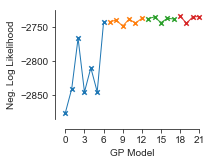

In [853]:
fig, ax = plt.subplots(1)

ax.plot(np.arange(0, 7, 1), lls1, linewidth = 1, label = 'Pass 1')
ax.scatter(np.arange(0, 7, 1), lls1, s = 20, clip_on = False, marker = 'x')

ax.plot(np.arange(0, 6, 1) + 7, lls2, linewidth = 1, label = 'Pass 2')
ax.scatter(np.arange(0, 6, 1) + 7, lls2, s = 20, clip_on = False, marker = 'x')

ax.plot(np.arange(0, 5, 1) + 13, lls3, linewidth = 1, label = 'Pass 3')
ax.scatter(np.arange(0, 5, 1) + 13, lls3, s = 20, clip_on = False, marker = 'x')

ax.plot(np.arange(0, 4, 1) + 18, lls4, linewidth = 1, label = 'Pass 4')
ax.scatter(np.arange(0, 4, 1) + 18, lls4, s = 20, clip_on = False, marker = 'x')

ax.set_xlim(0, 21)
plt.xticks(np.arange(0, 24, 3))
# ax.set_ylim(-950, -850)
# plt.yticks(np.arange(-1000, -800, 100))

ax.set_xlabel('GP Model', fontsize = 10)
ax.set_ylabel('Neg. Log Likelihood', fontsize = 10)

# plt.legend()
sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2.4, 2)

plt.savefig(directories['figs'] + 'oscillation/' + 'Iterative Kernel Selection.svg', dpi = 600)

In [841]:
likelihood_ratio = lambda LL_0, LL_1: 2 * (LL_1 - LL_0)

LL_0 = log_likelihoods_1[pass_1_max]
LL_1 = log_likelihoods_2[pass_2_max]
LL_2 = log_likelihoods_3[pass_3_max]
LL_3 = log_likelihoods_4[pass_4_max]

LLR = likelihood_ratio(LL_0, LL_1)
print(LLR)
p = chi2(1).sf(LLR) 
print('Second Pass (p): %.4f' % p)

LLR = likelihood_ratio(LL_1, LL_2)
print(LLR)
p = chi2(1).sf(LLR) 
print('Third Pass (p): %.4f' % p)

LLR = likelihood_ratio(LL_2, LL_3)
print(LLR)
p = chi2(1).sf(LLR)
print('Fourth Pass (p): %.4f' % p)

[[11.25467143]]
Second Pass (p): 0.0008
[[4.01946568]]
Third Pass (p): 0.0450
[[2.29280439]]
Fourth Pass (p): 0.1300


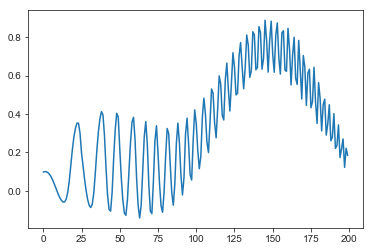

In [864]:
n_pnts = 25 * 8
trial_duration = np.mean(np.diff(off_sine['Triggertimes']))
freq_tpnts = np.linspace(0, 8, n_pnts)[:, None]

x_frequency = np.linspace(0, 8, n_pnts)[:, None]
x_contrast = np.ones(n_pnts)[:, None] * 100
freq_phase = ((freq_tpnts % 1) * x_frequency * 2 * np.pi) # % np.pi
x_cos = np.cos(freq_phase)
x_sin = np.sin(freq_phase)

X = np.concatenate([x_cos, x_sin, x_frequency, x_contrast], axis = 1)

freq_mu, freq_sig = gp_13.predict(X)

plt.plot(freq_mu)

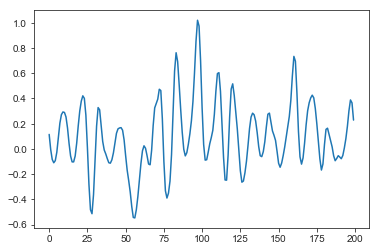

In [865]:
trial_duration = np.mean(np.diff(off_sine['Triggertimes']))
cont_tpnts = np.linspace(0, 8, n_pnts)[:, None]

x_frequency = np.ones(n_pnts)[:, None] * 2
x_contrast = np.linspace(0, 100, n_pnts)[:, None]
freq_phase = (cont_tpnts * trial_duration * x_frequency * 2 * np.pi) 
x_cos = np.cos(freq_phase)
x_sin = np.sin(freq_phase)

X = np.concatenate([x_cos, x_sin, x_frequency, x_contrast], axis = 1)

cont_mu, cont_sig = gp_13.predict(X, include_likelihood = False)

plt.plot(cont_mu)

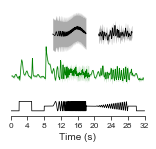

In [852]:
stimulus = h5py.File('misc/chirp.h5', 'r')['stimulusarray'][:]
stimulus_range = stimulus.max() - stimulus.min()
stimulus -= stimulus.min()
stimulus /= stimulus.max()

stimulus_time = np.linspace(0, 32, stimulus.shape[0])

sns.set_style('ticks')

tpnts = np.linspace(0, 8, 256) 

linewidth = 0.75
fig, ax = plt.subplots(1)

model_offset = 4

upper, lower = compute_bounds(freq_mu, freq_sig, n_sigma = 2)
ax.fill_between(freq_tpnts[:, 0] + 10, upper[:, 0] + model_offset, lower[:, 0] + model_offset, facecolor = 'k', alpha = 0.33)
upper, lower = compute_bounds(cont_mu, cont_sig, n_sigma = 2)
ax.fill_between(cont_tpnts[:, 0] + 21, upper[:, 0] + model_offset, lower[:, 0] + model_offset, facecolor = 'k', alpha = 0.33)
upper, lower = compute_bounds(mu, sig, n_sigma = 2)
ax.fill_between(x_new_unwarp - 33, upper[:, 0], lower[:, 0], facecolor = 'green', alpha = 0.33)

ax.plot(x_new_unwarp - 33, mu, color = 'green', linewidth = linewidth);

ax.plot(freq_tpnts + 10, freq_mu + model_offset, color = 'k', linewidth = linewidth)
ax.plot(cont_tpnts + 21, cont_mu + model_offset, color = 'k', linewidth = linewidth)

ax.plot(stimulus_time, stimulus - 4, color = 'k', linewidth = linewidth)

ax.set_xlim(0, 32)
plt.xticks(np.arange(0, 36, 4.0))
ax.set_xlabel('Time (s)', fontsize = 10)
ax.axes.get_yaxis().set_visible(False)
plt.tick_params(axis='both', which='major', labelsize='small')

sns.despine(left = True, ax = ax)

fig.set_size_inches(2.4, 2)

plt.savefig(directories['figs'] + 'oscillation/' + 'Chirp Prediction.svg', dpi = 600)

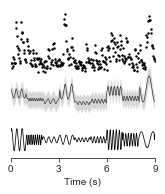

In [859]:
post_mu, post_sig = gp_13.predict(X, include_likelihood = False)

sns.set_style('ticks')

fig, ax = plt.subplots(1)

offset = 3
x_t = roi_df['t']

x_t_mask = (x_t > 32) & (x_t < 41) 
ax.scatter(x_t[x_t_mask], roi_df['y'][x_t_mask] + offset, s = 2, color = 'k', marker = 'o')
ax.plot(x_t[x_t_mask], post_mu[x_t_mask], linewidth = 0.5, color = 'k')

upper, lower = compute_bounds(post_mu, post_sig, n_sigma = 3)
ax.fill_between(x_t[x_t_mask], upper[x_t_mask, 0], lower[x_t_mask, 0], facecolor = 'k', alpha = 0.16)

stimulus_offset = -2.5
sine_mask = (sine_tpnts > 32) & (sine_tpnts < 41)  
ax.plot(sine_tpnts[sine_mask], sine_stimulus[sine_mask] - offset, linewidth = 0.75, color = 'k')

ax.get_yaxis().set_visible(False)
plt.xlim(32, 41)
plt.xticks(np.arange(0, 12, 3) + 32)
ax.set_xticklabels(np.arange(0, 12, 3))
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(left = True, ax = ax)

fig.set_size_inches(2.4, 2.8)

plt.tight_layout()

plt.savefig(directories['figs'] + 'oscillation/' + 'Fitted Osc GP.svg', dpi = 600)

In [874]:
i_freq = np.linspace(0, 8, 50)
i_cont = np.linspace(0, 100, 50)
n_freq = len(i_freq)
n_cont =  len(i_cont)
latent_uncertainty = np.zeros([n_freq, n_cont])

for itx, new_freq in enumerate(i_freq):
    x_new_frequency = np.linspace(0, 1, 50)
    
    for ity, new_cont in enumerate(i_cont):    
            X_predict = np.concatenate([
                    np.cos(x_new_frequency)[:, None],
                    np.sin(x_new_frequency)[:, None],
                    new_freq * np.ones(x_new_frequency.shape[0]).flatten(order = 'f')[:, None],
                    new_cont * np.ones(x_new_frequency.shape[0]).flatten(order = 'f')[:, None] 
            ], axis = 1)

            latent_uncertainty[itx, ity] = np.sum(gp_17.predict(X_predict, include_likelihood = False)[1])

from skimage.feature import peak_local_max

n_peaks = 5

peaks = peak_local_max(latent_uncertainty[3:, 5:],  min_distance = 3) + 1
peaks_order = latent_uncertainty[3:, 5:][peaks[:, 0], peaks[:, 1]].argsort()

peaks = peaks[peaks_order, :].astype(float)[:, ::-1]

peaks[:, 0] = (peaks[:, 0] + 5) /  n_cont * 100
peaks[:, 1] = (peaks[:, 1] + 3) / n_freq * 8

peaks = peaks[-n_peaks:, :]

# plt.scatter(peaks[:, 0], peaks[:, 1], color = 'g', s = 20, marker = 'x', clip_on = False)

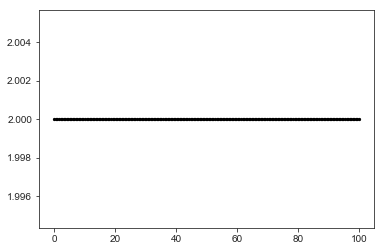

In [873]:
plt.scatter(x_contrast, x_frequency, color = 'k', s = 5, marker = 'o', clip_on = False, label = 'Sampled')


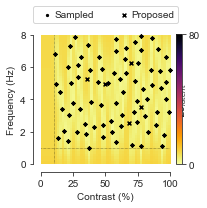

In [882]:
fig, ax = plt.subplots(1)

cax = ax.imshow(latent_uncertainty, origin = 'lower', cmap = 'inferno_r', extent = (0, 100, 0, 8), 
                aspect = 100 / 8, vmin = 0, vmax = 80)

ax.scatter(x_contrast, x_frequency, color = 'k', s = 5, marker = 'o', clip_on = False, label = 'Sampled')
ax.scatter(peaks[:, 0], peaks[:, 1], color = 'k', s = 15, marker = 'x', clip_on = False, label = 'Proposed')

ax.plot(np.ones(100) * 10, np.linspace(0, 8, 100), color = 'k', alpha = 1, linestyle = ':', linewidth = 0.5)
ax.plot(np.linspace(0, 100, 100), np.ones(100), color = 'k', alpha = 1, linestyle = ':', linewidth = 0.5)

plt.xlim(0, 100)
plt.xticks(np.arange(0, 125, 25))
ax.set_xlabel('Contrast (%)', fontsize = 10)

plt.ylim(0, 8)
plt.yticks(np.arange(0, 10, 2), fontsize = 10)
ax.set_ylabel('Frequency (Hz)')

plt.tick_params(axis='both', which='major', labelsize='medium')
sns.despine(ax = ax, offset = 8)

fig.set_size_inches(3.4, 3.4)

cbar = fig.colorbar(cax, ax = ax, ticks=[0, 80], 
                    fraction=0.046, pad=0.04)
cbar.set_label('$\Sigma \sigma_{latent}$', labelpad= -25, y=0.5, fontsize = 10)

plt.legend(ncol = 2, bbox_to_anchor = (-0.1, 1.05, 1, 0), handletextpad = -0.25)

plt.tight_layout()

fig.set_size_inches(2.8, 2.8)

plt.savefig(directories['figs'] + 'oscillation/' + 'Parameter Space.png', dpi = 600)